<a href="https://colab.research.google.com/github/BojanMakivic/Predicting-fitness-level-of-cancer-survivors/blob/master/Fastai_tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Update fastai library

In [ ]:
!pip install fastai --upgrade

# Mount the google drive

Here is link about how to mount google drive to Google Colab:
https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [3]:
# Python ≥3.5 
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd

# FastAi
import fastai
from fastai import *
from fastai.vision.all import *
from fastai.vision.data import *

# PyTorch
import torch

# Figures plot
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [4]:
from google.colab import files
import io

df = pd.read_excel('/content/drive/MyDrive/Data.xlsx')
df = pd.DataFrame(df)

In [ ]:
#df['Level']=np.where(df['Level']=="Bad",3,np.where(df['Level']=="Middle",2,1))
#df['Gender']=np.where(df['Gender']=="W",0,1)

In [5]:
# Function
def bmi(bw,bh):
    return bw/((bh/100)*(bh/100))

In [6]:
# Adding a new column
df['BMI']=bmi(df.iloc[:,2],df.iloc[:,3]) 

In [7]:
np.random.seed(42) # To ensure the repeatability of train/test results. It means that every time we run models the train/test samples will be same
del df['Norm']
del df['Type']
del df['Level']
#del df['Wmax'] # continuous

In [ ]:
#df=df.loc[df['Type'] == 'Brustkrebs']
#df=df.loc[df['Gender'] == 'W']
#df

# Train-test split

In [8]:
test_data = df.sample(frac=0.2, random_state=1)
train_data = df.loc[~df.set_index(list(df.columns)).index.isin(test_data.set_index(list(test_data.columns)).index)]
test_data

,Age,Sex,BW,BH,Wmax,BMI
111,60,W,50.0,165,44,18.365473
126,55,W,58.0,162,105,22.100290
701,29,W,60.0,157,129,24.341758
733,56,W,72.0,165,46,26.446281
898,61,M,80.0,178,209,25.249337
...,...,...,...,...,...,...
950,66,W,58.0,157,79,23.530366
702,72,W,72.0,176,87,23.243802
1289,59,M,89.0,181,164,27.166448
434,40,W,56.0,166,74,20.322253


In [9]:
start_indx = len(train_data) - int(len(train_data) * 0.2)
end_indx = len(train_data)

In [10]:
#Defining the keyword arguments for fastai's TabularList

from fastai.tabular.all import *
from fastai.torch_core import *
#Path / default location for saving/loading models
path = ''

#The dependent variable/target
dep_var = 'Wmax'
valid_idx=list(range(start_indx,end_indx))
#The list of categorical features in the dataset
cat_names = ['Sex'] 

#The list of continuous features in the dataset
#Exclude the Dependent variable 'Price'
cont_names =['Age', 'BH', 'BW', 'BMI'] 

#List of Processes/transforms to be applied to the dataset
procs = [FillMissing, Categorify, Normalize]

#Start index for creating a validation set from train_data
start_indx = len(train_data) - int(len(train_data) * 0.2)

#End index for creating a validation set from train_data
end_indx = len(train_data)

block_y = CategoryBlock()
#TabularList for Validation
val = TabularDataLoaders.from_df(train_data.iloc[start_indx:end_indx].copy(), path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)

test = TabularDataLoaders.from_df(test_data, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)

#TabularList for training
data = TabularDataLoaders.from_df(train_data,  databunch=1, add_test = test, y_names=dep_var, valid_idx=valid_idx, cat_names=cat_names, cont_names=cont_names, procs=procs, bs =64)
#,add_test(test),databunch()

# Model

In [11]:
#Initializing the network
learn = tabular_learner(data, layers=[1000], n_out=1, metrics= [rmse,R2Score(),accuracy, mae ], opt_func=Adam)

SuggestedLRs(valley=0.019054606556892395)

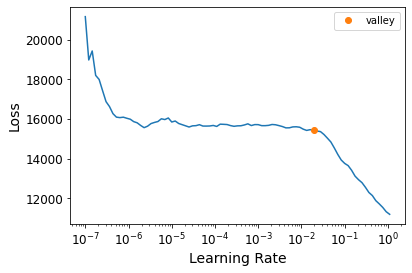

In [12]:
#Exploring the learning rates
lr = learn.lr_find()
lr

In [14]:
#Fitting data and training the network
learn.fine_tune(100, lr.valley)

epoch,train_loss,valid_loss,_rmse,r2_score,accuracy,mae,time
0,964.753967,1075.235840,32.790791,0.419331,0.000000,25.780130,00:00


epoch,train_loss,valid_loss,_rmse,r2_score,accuracy,mae,time
0,975.129700,1023.739624,31.995934,0.447141,0.000000,24.899879,00:00
1,966.299011,1040.584717,32.258095,0.438044,0.000000,25.341894,00:00
2,955.153503,1025.866089,32.029144,0.445993,0.000000,24.993370,00:00
3,961.928223,1029.872803,32.091633,0.443829,0.000000,25.018108,00:00
4,961.822266,1046.288330,32.346382,0.434964,0.000000,25.332703,00:00
5,956.330078,1020.148132,31.939756,0.449081,0.000000,24.873413,00:00
6,959.766113,1038.616699,32.227573,0.439107,0.000000,25.163231,00:00
7,952.325378,1018.590759,31.915369,0.449922,0.000000,24.979313,00:00
8,955.348267,1028.497437,32.070194,0.444572,0.000000,25.054121,00:00
9,961.647522,1035.478271,32.178848,0.440802,0.000000,25.199579,00:00


In [ ]:
#Display Predictions On Validation Data
learn.show_results(ds_type=val)

,Sex,Age,BH,BW,BMI,Wmax,Wmax_pred
0,1.0,0.745841,0.986996,0.519913,0.036611,135.0,143.691071
1,1.0,1.015357,1.883410,0.887206,-0.065259,125.0,154.750793
2,2.0,0.296648,-0.469677,0.458697,0.836188,102.0,106.002808
3,2.0,2.093421,0.650841,-0.459535,-0.823181,104.0,83.822105
4,2.0,0.386487,-0.805832,0.397482,0.989288,151.0,104.192574
5,2.0,-0.422061,-1.141987,-1.683845,-1.461744,82.0,89.457481
6,2.0,0.656003,-1.366091,0.397482,1.396319,94.0,98.208054
7,2.0,-0.152545,-0.021470,-0.153458,-0.150612,151.0,116.491173
8,2.0,0.206809,-1.254039,-0.888043,-0.371292,113.0,102.608429
